In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import imageio
import pathlib
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time
import tensorflow as tf
import os
from tqdm import tqdm

In [2]:
data_root = pathlib.Path('./Data/2A_images/train')
print(data_root)

Data/2A_images/train


In [3]:
# Read train.txt
train_df = pd.read_csv('./RawData/train_COVIDx_CT-2A.txt', sep=" ", header=None)
train_df.columns=['filename', 'label', 'xmin','ymin','xmax','ymax']
train_df=train_df.drop(['xmin', 'ymin','xmax', 'ymax'], axis=1 )
# Read val.txt
val_df = pd.read_csv('./RawData/val_COVIDx_CT-2A.txt', sep=" ", header=None)
val_df.columns=['filename', 'label', 'xmin','ymin','xmax','ymax']
val_df=val_df.drop(['xmin', 'ymin','xmax', 'ymax'], axis=1 )

test_df = pd.read_csv('./RawData/test_COVIDx_CT-2A.txt', sep=" ", header=None)
test_df.columns=['filename', 'label', 'xmin','ymin','xmax','ymax']
test_df=test_df.drop(['xmin', 'ymin','xmax', 'ymax'], axis=1 )

In [4]:
# labels={0:'Normal',1:'Pneumonia',2:'COVID-19'}
train_df.head()
train_df.label.value_counts()

2    82286
0    35996
1    25496
Name: label, dtype: int64

In [5]:
image_path = './Data/2A_images/'  #directory path
train_df['filepath'] = image_path+'train/'+train_df['filename']
val_df['filepath'] = image_path+'val/'+val_df['filename']
test_df['filepath'] = image_path +'test/'+ test_df['filename']
train_df.head()

,filename,label,filepath
0,NCP_96_1328_0032.png,2,./Data/2A_images/train/NCP_96_1328_0032.png
1,NCP_96_1328_0035.png,2,./Data/2A_images/train/NCP_96_1328_0035.png
2,NCP_96_1328_0036.png,2,./Data/2A_images/train/NCP_96_1328_0036.png
3,NCP_96_1328_0037.png,2,./Data/2A_images/train/NCP_96_1328_0037.png
4,NCP_96_1328_0038.png,2,./Data/2A_images/train/NCP_96_1328_0038.png


In [6]:
labels={0:'Normal',1:'Pneumonia',2:'COVID-19'}
class_names=['Normal','Pneumonia','COVID-19']

train_df['label_n']=[labels[b] for b in train_df['label']]
val_df['label_n']=[labels[b] for b in val_df['label']]
test_df['label_n']=[labels[b] for b in test_df['label']]
train_df.head()

,filename,label,filepath,label_n
0,NCP_96_1328_0032.png,2,./Data/2A_images/train/NCP_96_1328_0032.png,COVID-19
1,NCP_96_1328_0035.png,2,./Data/2A_images/train/NCP_96_1328_0035.png,COVID-19
2,NCP_96_1328_0036.png,2,./Data/2A_images/train/NCP_96_1328_0036.png,COVID-19
3,NCP_96_1328_0037.png,2,./Data/2A_images/train/NCP_96_1328_0037.png,COVID-19
4,NCP_96_1328_0038.png,2,./Data/2A_images/train/NCP_96_1328_0038.png,COVID-19


In [7]:
print(f"Negative and positive values of train: \n{train_df['label_n'].value_counts()}")
print(f"Negative and positive values of validation: \n{val_df['label_n'].value_counts()}")
print(f"Negative and positive values of test: \n{test_df['label_n'].value_counts()}")

Negative and positive values of train: 
COVID-19     82286
Normal       35996
Pneumonia    25496
Name: label_n, dtype: int64
Negative and positive values of validation: 
Normal       11842
Pneumonia     7400
COVID-19      6244
Name: label_n, dtype: int64
Negative and positive values of test: 
Normal       12245
Pneumonia     7395
COVID-19      6018
Name: label_n, dtype: int64


In [8]:
import random
Covid_path = random.sample(train_df[train_df['label'] == 2]['filename'].to_list(),3)
Pneumonia_path = random.sample(train_df[train_df['label'] == 1]['filename'].to_list(),3)
Normal_path = random.sample(train_df[train_df['label'] == 0]['filename'].to_list(),3)
#Image.open(train_df['filename'][idx])

Below is the sample images from the three categories. We can see that it is very hard for people who is not professional to distingiush between the three cases. Meanwhile, the differences among categories is not huge, hence shows that this project is very challenging. We are also very curious about if neural network can really help in detecting Covid xrays. Meanwhile, we think data augmentation is necessary to improve the diversity of the images and help the NN to better learn the categories. 

In [9]:
path = './Data/2A_images/train/'

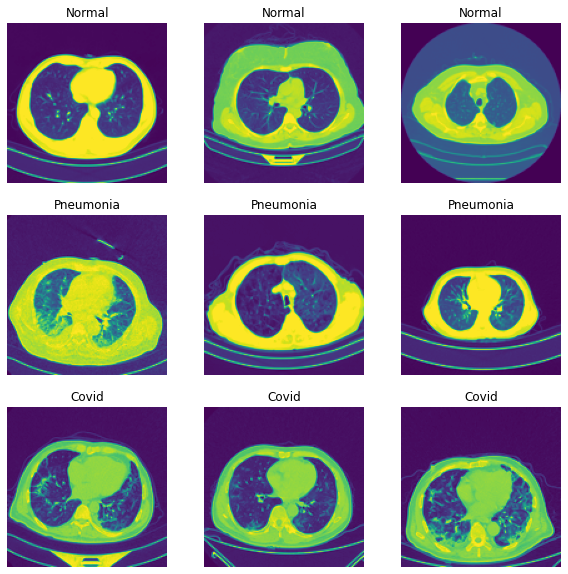

In [10]:
plt.figure(figsize=(10, 10))
    
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    if i<3:
        im = imageio.imread(path+Normal_path[i])
        plt.imshow(im)
        plt.title('Normal')
    elif i<6:
        im = imageio.imread(path+Pneumonia_path[i-3])
        plt.imshow(im)
        plt.title('Pneumonia') 
    else:
        im = imageio.imread(path+Covid_path[i-6])
        plt.imshow(im)
        plt.title('Covid')         
        
    plt.axis("off")

Data Augmentation

In [11]:
def other_adjustment(img):
    """
    input: images 
    output: images after adjustment
    """

    # saturation and hue were deleted since our data are in grayscale (1 channel)
    
    # random brightness
    temp_image = tf.image.random_brightness(img,
                                            64.0/255,
                                            seed=None)
    
    # random contrast
    temp_image = tf.image.random_contrast(temp_image,
                                          0,
                                          0.75,
                                          seed=None)

    return temp_image

Select small sample of 8 images and apply augmentation.

In [12]:
X = []
Y = []
for i in tqdm(range(3)):
    img0 = imageio.imread(path+Normal_path[i])
    img1 = imageio.imread(path+Pneumonia_path[i])
    img2 = imageio.imread(path+Covid_path[i])
    X.append(img0.reshape(128,128,1))
    Y.append('Normal')
    X.append(img1.reshape(128,128,1))
    Y.append('Pneumonia')
    X.append(img2.reshape(128,128,1))
    Y.append('Covid')
X = np.array(X)
Y = np.array(Y)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 282.36it/s]


In [13]:
print(X.shape, Y.shape)

(9, 128, 128, 1) (9,)


In [14]:
# Example code showing the correct imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
train_datagen = ImageDataGenerator(horizontal_flip = True,
                               vertical_flip = True,
                               rescale=1./255,
                               width_shift_range=(-8, 8),
                               height_shift_range=(-8, 8),
                               rotation_range = 90,
                               preprocessing_function=other_adjustment) 

train_generator = train_datagen.flow(X,Y,batch_size=9,shuffle=False)

Show image after processing

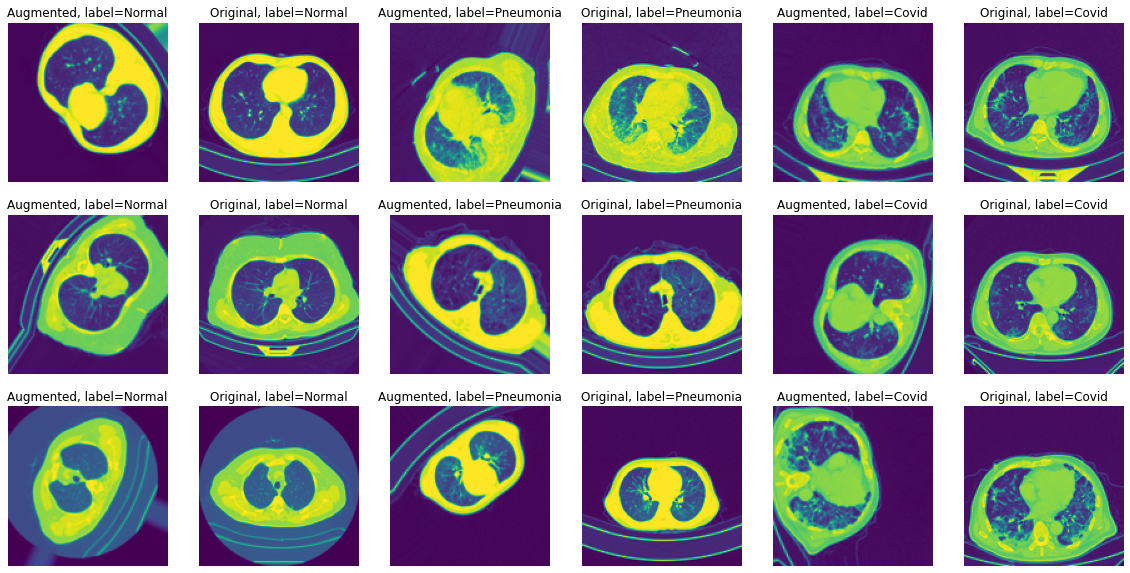

In [16]:
fig = plt.figure(figsize=(20,10))

x,y = train_generator.next()
for i in range(9):
    ax1 = fig.add_subplot(3, 6, 2*i+1)
    image1 = x[i]
    label1 = y[i]
    ax1.imshow(image1)
    ax1.set_title(f'Augmented, label={label1}')
    ax1.axis("off")
    
    ax2 = fig.add_subplot(3, 6, 2*i+2)
    image2 = X[i]
    label2 = Y[i]
    ax2.imshow(image2)
    ax2.set_title(f'Original, label={label2}')
    ax2.axis("off")

fig.show()    